This notebook analyzes the balance of labales in the dataset

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import nibabel as nib
import polars as pl
from tqdm import tqdm

In [ ]:
plt.style.use('seaborn-v0_8-white')

In [3]:
ROOT_PATH = os.getcwd()
TEST_LABELS_PATH = os.path.join(ROOT_PATH, "workspace/test/labelsTs/true")
TRAIN_LABELS_PATH = os.path.join(ROOT_PATH, "workspace/train/labelsTr")

In [4]:
label_annotations = {
    0: "Background",
    1: "PDAC lesion",
    2: "Veins",
    3: "Arteries",
    4: "Pancreas parenchyma",
    5: "Pancreatic duct",
    6: "Common bile duct",
}

In [27]:
def get_label_distribution(label_path):
    data = []
    label_files = [os.path.abspath(os.path.join(label_path, label_name)) for label_name in os.listdir(label_path)]
    label_files = [f for f in label_files if f.endswith(".nii.gz")]
    for label_file in tqdm(label_files, desc="Loading labels"):
        label = nib.load(os.path.realpath(label_file))
        data_arr = np.asanyarray(label.dataobj)
        
        unique, counts = np.unique(data_arr, return_counts=True)
        for label, count in tqdm(zip(unique, counts), desc="Counting pixels", total=len(unique)):
            data.append({
                "file": label,
                "label": int(label),
                "pixel_count": int(count)
            })
    counts_df = pl.DataFrame(data)
    distribution_f = (
        counts_df.group_by("label")
        .agg([
            pl.col("pixel_count").sum().alias("total_pixels"),
            pl.col("file").n_unique().alias("file_count")
        ])
        .sort("label")
    )
    return distribution_f

In [ ]:
# training_labels = get_label_distribution(TRAIN_LABELS_PATH)
# training_labels.write_csv(os.path.join(TRAIN_LABELS_PATH, "training_labels.csv"))

Loading labels:   0%|          | 2/719 [01:02<6:11:53, 31.12s/it]


KeyboardInterrupt: 

In [ ]:
testing_labels = get_label_distribution(TEST_LABELS_PATH)
testing_labels.write_csv(os.path.join(TEST_LABELS_PATH, "testing_labels.csv"))

'testing_labels = get_label_distribution(os.path.join(DATA_PATH, "labelsTs"))\ntesting_labels.write_csv(os.path.join(DATA_PATH, "testing_labels.csv"))'

In [ ]:
# load label distributions
training_labels = pl.read_csv(os.path.join(TRAIN_LABELS_PATH, "training_labels.csv"))
testing_labels = pl.read_csv(os.path.join(TEST_LABELS_PATH, "testing_labels.csv"))

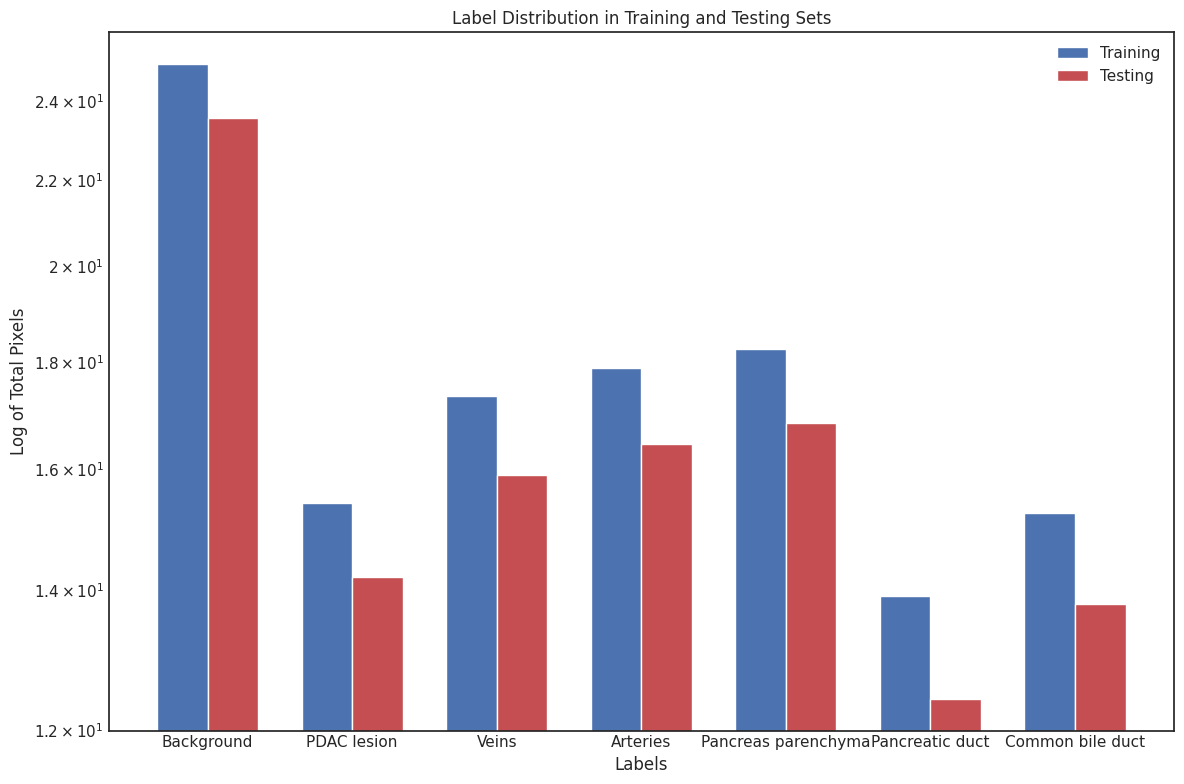

In [ ]:
# plot average pixels per label (category) for training and testing sets
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(label_annotations))

# Calculate average pixels per label
training_avg = training_labels["total_pixels"] / training_labels["total_pixels"].sum()
testing_avg = testing_labels["total_pixels"] / testing_labels["total_pixels"].sum()

# Plot training averages
ax.bar(index, training_avg, bar_width, label="Training", color='b')

# Plot testing averages
ax.bar(index + bar_width, testing_avg, bar_width, label="Testing", color='r')

ax.set_ylabel("Average Pixels per File")
ax.set_xlabel("Labels")
ax.set_title("Average Label Distribution in Training and Testing Sets")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([label_annotations[i] for i in range(len(label_annotations))])
ax.legend()

plt.tight_layout()
plt.show()